# This notebook uses Hail Library to subset 1000Genomes data randomly.

### You can run this notebook on an AWS EMR cluster
### - https://aws.amazon.com/marketplace/pp/AEHRC-VariantSpark-Notebook/B07YVND4TD
### - https://youtu.be/qum5Q8sQQtw

### Filtered data can be used as input for PEPS 
### https://github.com/aehrc/PEPS


### To run this notebook change the path below.

In [1]:
numCPU=32
numPartition=numCPU*2
DIR='s3://variant-spark/GigaScience/Data/PEPS_Genotypes/'
OUTPUT=DIR+'PEPS-1000Genome-Subset-B.vcf.bgz'

# Intialisation

In [2]:
%%juspark
{"spark.driver.memory":"24G","spark.jars":"/home/hadoop/miniconda2/envs/jupyter/lib/python2.7/site-packages/varspark/jars/variant-spark_2.11-0.2.0-all.jar"}

PySpark initialised: spark context available as sc


In [3]:
import hail
import varspark.hail
from hail import KeyTable
from hail.keytable import asc
from hail.keytable import desc

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from math import log, isnan
from pprint import pprint
from decimal import Decimal
from pyspark.sql.functions import *
from datetime import datetime

In [4]:
hc = hail.HailContext(sc)

Running on Apache Spark version 2.2.1
SparkUI available at http://ip-172-31-17-246.ap-southeast-2.compute.internal:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.1-20613ed


# Path to data

In [5]:
G1000VDS='s3://variant-spark/GigaScience/Data/1000Genomes/subset.0.vds'

# Load data and randomly pick 1M SNPs

In [6]:
vds = hc.read(G1000VDS).sample_variants(0.01224781698891).repartition(numPartition).cache()

In [7]:
vds.count()

(2504L, 1000174L)

# Find number of variables with different MAF Thresold

In [8]:
xvds = vds.variant_qc().annotate_variants_expr('va.qc.MAF = if(va.qc.AF > 0.5) (1 - va.qc.AF) else (va.qc.AF)')

In [9]:
xvds.count()

(2504L, 1000174L)

In [10]:
xvds.filter_variants_expr('va.qc.MAF > 0.2').count()

(2504L, 49893L)

In [11]:
xvds.filter_variants_expr('va.qc.MAF > 0.1').count()

(2504L, 75542L)

In [12]:
xvds.filter_variants_expr('va.qc.MAF > 0.05').count()

(2504L, 97468L)

In [13]:
xvds.filter_variants_expr('va.qc.MAF > 0.01').count()

(2504L, 167984L)

In [14]:
xvds.filter_variants_expr('va.qc.MAF > 0.001').count()

(2504L, 355007L)

# 0.05 is an appropriate threashold

In [15]:
vds = xvds.filter_variants_expr('va.qc.MAF > 0.05')

# Annotate poulation

In [16]:
sa = hc.import_table(DIR+'igsr_samples.tsv', impute=True)\
.select(['Sample_name', 'Sex', 'Superpopulation_code']).rename(['sample','sex','pop']).key_by('sample')\
.annotate('pc = if(pop=="SAS") 0.1 else (if(pop=="EAS") 0.2 else (if(pop=="EUR") 0.3 else (if(pop=="AMR") 0.4 else 0.5)))')


2020-01-28 23:28:40 Hail: INFO: Reading table to impute column types
2020-01-28 23:28:40 Hail: INFO: Finished type imputation
  Loading column `Sample_name' as type String (imputed)
  Loading column `Sex' as type String (imputed)
  Loading column `Biosample_ID' as type String (imputed)
  Loading column `Population_code' as type String (imputed)
  Loading column `Population_name' as type String (imputed)
  Loading column `Superpopulation_code' as type String (imputed)
  Loading column `Superpopulation_name' as type String (imputed)
  Loading column `Population_elastic_ID' as type String (imputed)
  Loading column `Data_collections' as type String (imputed)


In [17]:
vds = vds.annotate_samples_table(sa, root='sa.pheno')

In [18]:
vds.samples_table().to_pandas().groupby('sa.pheno.pop').count()

,s,sa.pheno.sex,sa.pheno.pc
sa.pheno.pop,,,
AFR,661,661,661
AMR,347,347,347
EAS,504,504,504
EUR,503,503,503
SAS,489,489,489


# Filter SNPs that describes populations

In [19]:
vds = vds.linreg(root='va.pp' , y='sa.pheno.pc')

2020-01-28 23:28:42 Hail: INFO: Running linear regression on 2504 samples with 1 covariate including intercept...


In [20]:
vds = vds.filter_variants_expr('va.pp.pval > 0.01')
vds.count()

(2504L, 14687L)

# Remove non-SNP (indels)

In [21]:
vds = vds.filter_variants_expr('v.altAlleles[0].alt.length()!=1 || v.altAlleles[0].ref.length()!=1', keep=False)
vds.count()

(2504L, 12710L)

# PCA

2020-01-28 23:30:30 Hail: INFO: Running PCA with 2 components...


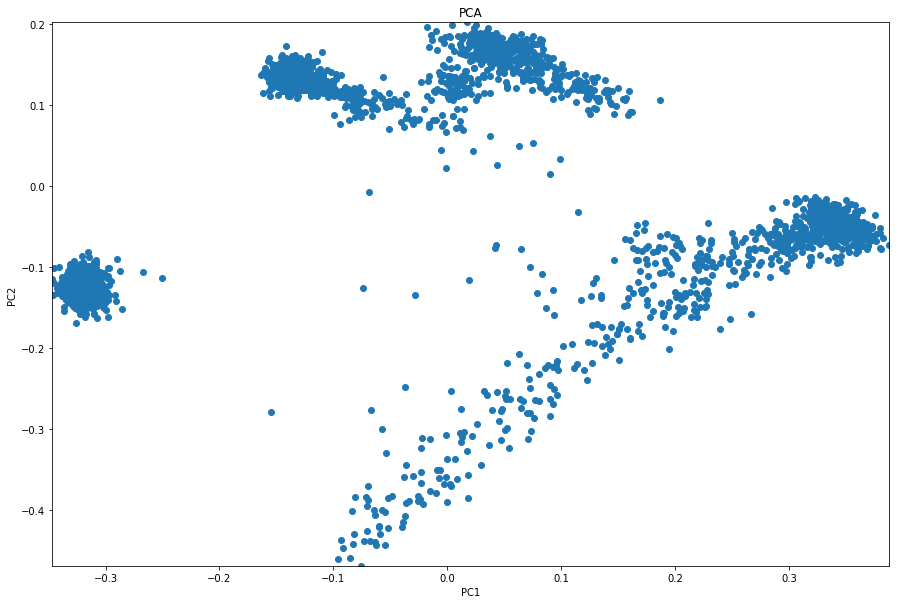

In [22]:
pca_kt = vds.cache().pca(k=2, scores='sa.pca_score')\
.samples_table().flatten().select(['s', 'sa.pca_score.PC1', 'sa.pca_score.PC2'])\
.rename(['s', 'PC1', 'PC2'])

pca_table = pca_kt.to_pandas()


#colors = {True: 'yellow', False: 'black'}
plt.figure(figsize=(15,10))
plt.scatter(pca_table["PC1"], pca_table["PC2"])
plt.xlim(pca_table["PC1"].min(), pca_table["PC1"].max())
plt.ylim(pca_table["PC2"].min(), pca_table["PC2"].max())
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA")

plt.show()

vds = vds.annotate_samples_table(pca_kt, root='sa.pca')

# Export as VCF

In [23]:
vds.export_vcf(OUTPUT)

2020-01-28 23:32:31 Hail: INFO: while writing:
    s3://variant-spark/GigaScience/Data/PEPS_Genotypes/PEPS-1000Genome-Subset-B.vcf.bgz
  merge time: 581.741ms
